## Equilibrium thermal slab

This model is loosely based on the modelling approaches in: 

* van Hunen (2008)
* Ratnaswamy (2016)
* Rodríguez-González (2016)

In particular:

* the model employs a kinemetic phase where the subducting plate (a thermal boundary later with a temperature profile defined by an a priori constant velocity) is driven toward the incipient subduction zone until it has the required buoyancy required for ongoing subduction. 
* Like in van Hunen (2008), we iterate until the dynamic and kinematic velocity phases are suitably close.
* In addition we also seek stablility in slab dip in the kinematic / dynamic phases
* A plate boundary weak zone decouples the upper and lower plates, this is also compated to lubrication by crustal material
* Non-linear, shear thinning creep is included




In [111]:
import networkx as nx
import underworld as uw
import math
from underworld import function as fn
import glucifer
#import matplotlib.pyplot as pyplot
import time
import numpy as np
import os
import sys
import natsort
import shutil
from easydict import EasyDict as edict
import slippy2 as sp
import operator
import pint

from slippy2 import boundary_layer2d
from slippy2 import material_graph


from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

In [112]:
############
#Model name.  
############
Model = "T"
ModNum = 0

if len(sys.argv) == 1:
    ModIt = "Base"
elif sys.argv[1] == '-f':
    ModIt = "Base"
else:
    ModIt = str(sys.argv[1])

In [113]:
###########
#Standard output directory setup
###########


outputPath = "results" + "/" +  str(Model) + "/" + str(ModNum) + "/" + str(ModIt) + "/"
imagePath = outputPath + 'images/'
filePath = outputPath + 'files/'
checkpointPath = outputPath + 'checkpoint/'
dbPath = outputPath + 'gldbs/'
outputFile = 'results_model' + Model + '_' + str(ModNum) + '_' + str(ModIt) + '.dat'

if uw.rank()==0:
    # make directories if they don't exist
    if not os.path.isdir(outputPath):
        os.makedirs(outputPath)
    if not os.path.isdir(checkpointPath):
        os.makedirs(checkpointPath)
    if not os.path.isdir(imagePath):
        os.makedirs(imagePath)
    if not os.path.isdir(dbPath):
        os.makedirs(dbPath)
    if not os.path.isdir(filePath):
        os.makedirs(filePath)
        
comm.Barrier() #Barrier here so no procs run the check in the next cell too early 

In [114]:
###########
#Check if starting from checkpoint
###########

checkdirs = []
for dirpath, dirnames, files in os.walk(checkpointPath):
    if files:
        print dirpath, 'has files'
        checkpointLoad = True
        checkdirs.append(dirpath)
    if not files:
        print dirpath, 'is empty'
        checkpointLoad = False
        

results/T/0/Base/checkpoint/ is empty


In [115]:
###########
#Use pint to setup any unitconversions we'll need
###########


u = pint.UnitRegistry()
cmpery = u.cm/u.year
mpermy = u.m/u.megayear

cmpery.to(mpermy)

<Quantity(10000.0, 'meter / megayear')>

In [116]:
###########
#Physical parameters
###########

#dimensional parameter dictionary
dp = edict({'LS':1500.*1e3,
           'rho':3300,
           'g':9.81, 
           'eta0':1e20,
           'k':10**-6,
           'a':3e-5, 
           'deltaT':1400,
           'TS':273.,
           'TB':1673.,
           'SR':1e-15,
           'cohesion':20e6,
           'fc':0.02,
           'E':240000.,
           'R':8.314,
           'StALS': 27.*1e3,
           'V':6.34*(10**-7),
           'G':8e10, 
           'plate_vel':2}) 


#scale_factors

sf = edict({'stress':dp.LS**2/(dp.k*dp.eta0),
            'lith_grad':dp.rho*dp.g*(dp.LS)**3/(dp.eta0*dp.k) ,
            'vel':dp.LS/dp.k,
            'SR':dp.LS**2/dp.k,
            'W':(dp.rho*dp.g*dp.LS)/(dp.R*dp.deltaT), #This is the activation energy scale, in terms of depth (not pressure)
            'E': 1./(dp.R*dp.deltaT)})

#dimensionless parameters

ndp = edict({'RA':(dp.g*dp.rho*dp.a*dp.deltaT *(dp.LS)**3)/(dp.k*dp.eta0),
            'cohesion':dp.cohesion*sf.stress,
            'fcd':dp.fc*sf.lith_grad,
            'TS':0., 
            'TB':1.,
            'TSp':(dp.TS/dp.deltaT),
            'TBp':(dp.TS+dp.deltaT/dp.deltaT),
            'TRp': 1300./dp.deltaT,
            'RD':100e3/dp.LS,
            'SR': dp.SR*sf.SR,
            'n':3.,
            'low_visc':1e-4,
            'StAeta0':0.01,
            'up_visc':1e5,
            'W': dp.V*sf.W,
            'E':dp.E*sf.E,
            'H':0.,
            'G':dp.G*sf.stress,
            'plate_vel':sf.vel*dp.plate_vel*(cmpery.to(u.m/u.second)).magnitude, 
            'Tmvp':0.6})


In [117]:
sf.SR

2.25e+18

In [118]:
ndp.plate_vel

950.6629392245547

In [119]:
#origRA = ndp.RA 
#ndp.RA  = 5e8
#ndp.cohesion = ndp.cohesion*(ndp.RA/origRA)
#ndp.plate_vel 
#ndp.W, ndp.E
#ndp.RA 

In [120]:
#Flags for different mechanisms

crust_buoyancy = True
ecl_buoyancy = True
stress_dependent = False
lower_mantle = True
melt_viscosity_reduction= False

In [121]:
ETAREF = dp.rho*dp.g*dp.a*dp.deltaT*((dp.LS)**3)/(ndp.RA*dp.k) #equivalent dimensional reference viscosity
#RC = (3300.*dp.g*(dp.LS)**3)/(ETAREF *dp.k) #Composisitional Rayleigh number for rock-air buoyancy force
RCA = (1650.*dp.g*(dp.LS)**3)/(ETAREF *dp.k) #Composisitional Rayleigh number for rock-air buoyancy force
COMP_RA_FACT_AIR = RCA/ndp.RA
#RCC = (100.*dp.g*(dp.LS)**3)/(ETAREF *dp.k) #Composisitional Rayleigh number for crust
#COMP_RA_FACT_CRUST = RCC/ndp.RA
#RCE = -1*(200.*dp.g*(dp.LS)**3)/(ETAREF *dp.k) #Composisitional Rayleigh number for eclogite 
#COMP_RA_FACT_ECL = RCE/ndp.RA
ndp["StA_RA"] = ndp.RA*COMP_RA_FACT_AIR

In [122]:
#A few parameters defining lengths scales, affects materal transistions etc.
MANTLETOCRUST = (20.*1e3)/dp.LS #Crust depth
CRUSTTOMANTLE = (900.*1e3)/dp.LS 
LITHTOMANTLE = (900.*1e3)/dp.LS 
MANTLETOLITH = (200.*1e3)/dp.LS 
TOPOHEIGHT = (0.*1e3)/dp.LS  #rock-air topography limits
CRUSTTOECL  = (100.*1e3)/dp.LS
AVGTEMP = ndp.TB #Used to define lithosphere

In [123]:
LITHTOMANTLE 

0.6

In [124]:
###########
#Model setup parameters
###########

stickyAir = False

MINX = -(3000e3/dp.LS)
MINY = 0.
MAXX = (3000e3/dp.LS)

#MAXY = 1.035
MAXY = 1.

if MINX == 0.:
    squareModel = True
else: 
    squareModel = False
    
    
dim = 2          # number of spatial dimensions


#MESH STUFF

RES = 64


Xres = int(RES*4)


if stickyAir:
    Yres = RES
    MAXY = 1. + dp.StALS/dp.LS #150km
    
else:
    Yres = RES
    MAXY = 1.


periodic = [True, False]
elementType = "Q1/dQ0"
#elementType ="Q2/DPC1"

refineMesh = True

#System/Solver stuff

PIC_integration=True
ppc = 25

In [125]:
###########
#Model Runtime parameters
###########

swarm_update = 5
swarm_repop = 5
files_output = 1
gldbs_output = 5
images_output = 1e6
checkpoint_every = 25
metric_output = 25
sticky_air_temp = 10
new_passive_particle = 10 #How often to add new particles at 'source' points


comm.Barrier() #Barrier here so not procs run the check in the next cell too early 

assert metric_output <= checkpoint_every, 'Checkpointing should run less or as ofen as metric output'
#assert (metric_output >= swarm_update), 'Swarm update is needed before checkpointing'
#assert metric_output >= sticky_air_temp, 'Sticky air temp should be updated more frequently that metrics'

In [126]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = elementType,
                                 elementRes  = (Xres, Yres), 
                                 minCoord    = (MINX,MINY), 
                                 maxCoord=(MAXX,MAXY), periodic=periodic)



velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=dim )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

In [127]:
# Initialise data.. Note that we are also setting boundary conditions here
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.
temperatureField.data[:] = 0.
temperatureDotField.data[:] = 0.

## Plates, slabs, thermal geometry

In [128]:
###########
#Boundary layer / slab paramaters
###########

subzone = -500.e3/dp.LS
mor = (3000e3/dp.LS) - (1000e3/dp.LS)
vel =  dp.plate_vel*cmpery.to(mpermy).magnitude #The boundary_later2d function wants m/my
agelimit = False
thermallimit = 1.0

#Slab perturbation paramaters
Roc = 450.
theta = 89.

In [129]:
#This sets up the appropriate half space cooling stencil for the domain

lith= boundary_layer2d.LithosphereTemps(mesh, temperatureField, dp.LS, subzone, mor, tint=ndp.TB, tsurf=ndp.TS, vel= vel, diffs = 1e-6)


In [130]:
#coords = [((-1*1500e3)/dp.LS-1e-6, 1.), (subzone, 1.+1e-6), ((-1*1500e3)/dp.LS-1e-6, (1. - 670e3/dp.LS))]
#Tri = fn.shape.Polygon(np.array(coords))

In [131]:
for index, coord in enumerate(mesh.data):
    xloc = coord[0]
    agema = lith.agefunc(xloc)
    if coord[1] >= 1.:
            temperatureField.data[index] = lith.tsurf
    else:
        zloc = ((1.- coord[1])* dp.LS) # dimensional depth kms
        t = lith.tempfunc(agema, zloc)
        temperatureField.data[index] = t 
    if (coord[1] <= 1. and coord[0] > mor) or coord[0] < subzone: #Get rid of lithosphere to the right of the ridge
        temperatureField.data[index] = lith.tint
    #if Tri.evaluate(tuple(coord)):
    #    temperatureField.data[index] = lith.tint

In [132]:
def inCircleFnGenerator(centre, radius):
    coord = fn.input()
    offsetFn = coord - centre
    return fn.math.dot( offsetFn, offsetFn ) < radius**2

#Setup slab perturbation params (mostly dimensionles / model params here)
phi = 90. - theta
RocM = (Roc/dp.LS)*1e3
CrustM = MANTLETOCRUST
#slabdepth = lithdepthfunc(agefunc(off, off, vel), dp.k)
slabdepthM = lith.lithdepthfunc(lith.agefunc(subzone)) /dp.LS
#slabdepthM *= 5.
Org = (0.+subzone, 1.-RocM)
#Use three circles to define our slab and crust perturbation,  
Oc = inCircleFnGenerator(Org , RocM)
Gc = inCircleFnGenerator(Org , RocM + (50e3/dp.LS)) #a slightly larger circle for the 'gap'
Ic = inCircleFnGenerator(Org , RocM - slabdepthM)
Cc = inCircleFnGenerator(Org , RocM - CrustM)
dx = (RocM)/(np.math.tan((np.math.pi/180.)*phi))

In [133]:
#Work our which way the slab should face:
sense = 'Left'
#if lith.agefunc(subzone + 0.0001) < lith.agefunc(subzone - 0.0001):
#    sense = 'Right'

#We'll also create a triangle which will truncate the circles defining the slab...
if sense == 'Left': 
    ptx = subzone - dx
else:
    ptx = subzone + dx

coords = ((0.+subzone, 1), (0.+subzone, 1.-RocM), (ptx, 1.))
Tri = fn.shape.Polygon(np.array(coords))

In [134]:
#Assign temperatures in the perturbation region
#sds = []
if sense == 'Left': 
    age = lith.agefunc(subzone + 0.001)
else:
    age = lith.agefunc(subzone - 0.001)
    
if agelimit:
        age = min(agelimit, age)
                

for index, coord in enumerate(mesh.data):
    #if Oc.evaluate(tuple(coord)) and Tri.evaluate(tuple(coord)) and not Ic.evaluate(tuple(coord)): #in inner circle, not in outer circle
    if Oc.evaluate(tuple(coord)) and Tri.evaluate(tuple(coord)): #In the quarter-circle defining the lithosphere
  
        sd = ((RocM - math.sqrt((coord[0] - Org[0])**2 + (coord[1] - Org[1])**2))*dp.LS) #distance from slab edge in m
        #print sd
        if thermallimit:
            if sd < (lith.lithdepthfunc(age))*thermallimit: #comparison of dimensionless (model) lengths
                t = lith.tempfunc(age, sd)
                temperatureField.data[index] = t
        else:
            t = lith.tempfunc(age, sd)
            temperatureField.data[index] = t
    if Gc.evaluate(tuple(coord)) and Tri.evaluate(tuple(coord)) and not Oc.evaluate(tuple(coord)):
        temperatureField.data[index] =  lith.tint
    if coord[1] <= (1. - 250e3/dp.LS): #Get rid of slab beneath given cutfof
        temperatureField.data[index] = lith.tint

In [135]:
figTemp = glucifer.Figure()
figTemp.append( glucifer.objects.Surface(mesh, temperatureField))

#figTemp.save_database('test.gldb')
#figTemp.show()

In [136]:
# send boundary condition information to underworld
IWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
JWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
TWalls = mesh.specialSets["MaxJ_VertexSet"]
BWalls = mesh.specialSets["MinJ_VertexSet"]

In [137]:
#Get indexSet for the plate

Fixed = mesh.specialSets["Empty"]
for index in list(TWalls.data):
    if (mesh.data[int(index)][0] > subzone) and (mesh.data[int(index)][0] < mor):
        Fixed.add(int(index))
        #Set the plate velocities for the kinematic phase
        #velocityField.data[index] = [-1.*ndp.plate_vel, 0.]
        


In [138]:
#Fixed.data.shape, TWalls.data.shape
lith.tsurf

0.0

In [139]:
#Set Dirichlet Temp conditions

for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = lith.tint
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = lith.tsurf


# Now setup the dirichlet boundary condition
# Note that through this object, we are flagging to the system 
# that these nodes are to be considered as boundary conditions. 
# Also note that we provide a tuple of sets.. One for the Vx, one for Vy.
freeslipBC = uw.conditions.DirichletCondition(     variable=velocityField, 
                                              indexSetsPerDof=(IWalls, JWalls) )

# also set dirichlet for temp field
dirichTempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              indexSetsPerDof=(JWalls,) )

# Particles

In [140]:
###########
#Material Swarm and variables
###########

gSwarm = uw.swarm.Swarm(mesh=mesh)
materialVariable = gSwarm.add_variable( dataType="int", count=1 )
yieldingCheck = gSwarm.add_variable( dataType="int", count=1 )

###########
#Passive Swarms and variables
###########


#midlith = 1. - lith.lithdepthfunc(lith.agefunc(add_point))/dp.LS
midlith = 1. - (50e3/dp.LS)

#Add particles at midlithosphere
add_point = subzone + (50e3/dp.LS)

midSwarm = uw.swarm.Swarm(mesh=mesh)
midSwarm.add_particles_with_coordinates(np.array([[add_point,  midlith]]))



array([0], dtype=int32)

In [141]:
mantleIndex = 0
lithosphereIndex = 1
eclIndex = 2
crustIndex = 3
airIndex = 4
tempIndex = 5




if checkpointLoad:
    checkpointLoadDir = natsort.natsorted(checkdirs)[-1]
    temperatureField.load(os.path.join(checkpointLoadDir, "temperatureField" + ".hdf5"))
    pressureField.load(os.path.join(checkpointLoadDir, "pressureField" + ".hdf5"))
    velocityField.load(os.path.join(checkpointLoadDir, "velocityField" + ".hdf5"))
    gSwarm.load(os.path.join(checkpointLoadDir, "swarm" + ".h5"))
    for ix in range(len(varlist)):
        varb = varlist[ix]
        varb.load(os.path.join(checkpointLoadDir,varnames[ix] + ".h5"))

else:

    # Layouts are used to populate the swarm across the whole domain
    # Create the layout object
    layout = uw.swarm.layouts.PerCellRandomLayout(swarm=gSwarm, particlesPerCell=ppc)
    # Now use it to populate.
    gSwarm.populate_using_layout( layout=layout )

    # Lets initialise the 'materialVariable' data to represent different materials
    # Set the material to heavy everywhere via the numpy array
    materialVariable.data[:] = mantleIndex
    
    
    #Set initial air and crust materials (allow the graph to take care of lithsophere)
    #########
    #This initial material setup will be model dependent
    #########
    for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
        if (1. - gSwarm.particleCoordinates.data[particleID][1]) < 0:
                 materialVariable.data[particleID] = airIndex
        elif (1. - gSwarm.particleCoordinates.data[particleID][1]) < MANTLETOCRUST:
                 materialVariable.data[particleID] = crustIndex


# Material Graphs

In [142]:
from networkx import DiGraph
import uuid


In [143]:
coordinate = fn.input()
depthFn = 1. - coordinate[1]

In [144]:
##############
#Important: This is a quick fix for a bug that arises in parallel runs
##############
material_list = [0,1,2,3]


In [145]:
#All depth conditions are given as (km/D) where D is the length scale,
#note that 'model depths' are used, e.g. 1-z, where z is the vertical Underworld coordinate
#All temp conditions are in dimensionless temp. [0. - 1.]

materialVariable.data[:] = 0

#######Graph object
#DG = nx.DiGraph(field="Depth")
DG = material_graph.MatGraph()

#Important: First thing to do is to add all the material types to the graph (i.e add nodes)
DG.add_nodes_from(material_list)


#######Edges
#anything to air


#Anything to mantle
#DG.add_transition((3,0), depthFn, operator.gt, CRUSTTOMANTLE)
DG.add_transition((1,0), depthFn, operator.gt, 0.5 )
#DG.add_transition((2,0), depthFn, operator.gt, CRUSTTOMANTLE)



#Anything to crust
#DG.add_transition((0,3), depthFn, operator.lt, MANTLETOCRUST)
DG.add_transition((1,3), depthFn, operator.lt, MANTLETOCRUST)
#DG.add_transition((4,3), depthFn, operator.lt, TOPOHEIGHT)

#Anything to lithsphere
DG.add_transition((0,1), depthFn, operator.lt, MANTLETOLITH)
DG.add_transition((0,1), temperatureField, operator.lt, 0.85*AVGTEMP)



#crust to eclogite
#DG.add_edges_from([(3,2)])
#DG[3][2]['depthcondition'] =CRUSTTOECL
#DG.add_transition((3,2), depthFn, operator.gt, CRUSTTOECL)

In [146]:
#%matplotlib inline
#nx.draw(DG,pos=nx.spring_layout(DG), with_label=True, cmap='jet')

In [148]:
DG.build_condition_list(materialVariable)

In [106]:
for i in range(2): #Need to go through twice first time through
    materialVariable.data[:] = fn.branching.conditional(DG.condition_list).evaluate(gSwarm)

In [150]:
DG.condition_list

[(<underworld.function._function.logical_and at 0x11f15ccd0>, 1),
 (<underworld.function._function.logical_and at 0x11fa91050>, 0),
 (<underworld.function._function.logical_and at 0x11fa91bd0>, 3),
 (True, <underworld.swarm._swarmvariable.SwarmVariable at 0x11f10a4d0>)]

In [107]:
figMat = glucifer.Figure()
figMat.append( glucifer.objects.Points(gSwarm,materialVariable))
#figMat.append( glucifer.objects.Mesh(mesh))
#figMat.save_database('test.gldb')
#figMat.show()

In [108]:
np.unique(materialVariable.data[:])

array([0, 1, 3], dtype=int32)

## Rheology

In [109]:
############
#Rheology
#############
#
#The final mantle rheology is composed as follows*:
# 
#
# mantleviscosityFn = min{min{omega*eta_arr, eta_max}, 
#                         max{eta_p, eta_min}}
#                      
#eta_min => min allowable viscosity
#eta_max => max allowable viscosity
#eta_arr => arhennius viscosity (could be linear or non linear)
#eta_p   => stress-limiting effective viscosity
#omega   => a field that accounts for fuzzy physics - plate boundary shear zones, lower mantle, melt viscosity reduction
#
#Note the when nonlinearity is activated for the arhennius, the non_linear_correction term is truncated
# final_non_linear_correction = max{100., 
#                                   min{0.01, non_linear_correction}}
#
#
#
# *an alternative way of composing similar rheology 'elements' can be found in Ratnaswamy (2016))

omega = fn.misc.constant(1.)


#implementation of the melt viscosity reduction, similar to Crameri and Tackley. 2015

if melt_viscosity_reduction:
    mvr =  fn.branching.conditional( [ (temperatureField > (ndp.Tmvp + 7.5*(1. - coordinate[1])) , 0.1 ),   (         True, 1.) ] )
    omega = omega*mvr


#implementation of the lower mantle viscosity increase, similar to Bello et al. 2015
a = 1.
B = 30.
d0 = 660e3/dp.LS  
ds = d0/10.
if lower_mantle:
    inner1 = 1. - 0.5*(1. - fn.math.tanh(((1. - d0)-(coordinate[1]))/(ds)))
    modfac = a*fn.math.exp(np.log(B)*inner1)
    omega = omega*modfac

############
#Mantle
############

#linear viscosity
linearVisc = fn.misc.min(ndp.up_visc,omega*fn.math.exp(((ndp.E + ndp.W*(depthFn))/
                                         (temperatureField + ndp.TSp)) - 
                                         ((ndp.E + ndp.W*(1.- ndp.RD))/(ndp.TRp + ndp.TSp))))

arhennius = linearVisc


#stress (strain rate) dependent non-linear viscosity
if stress_dependent:
    nl_correction = (strainRate_2ndInvariant/ndp.SR)**((1.-ndp.n)/(ndp.n))
    nl_correction_final = fn.misc.min(10., fn.misc.max(0.1, nl_correction))
    #arhennius = fn.misc.max(ndp.low_visc, (fn.misc.min(ndp.up_visc,(omega*nl_correction_final*fn.math.exp(((ndp.E + ndp.W*(depthFn))/
    #                                     (ndp.n*(temperatureField + ndp.TSp))) - 
    #                                     ((ndp.E + ndp.W*(1.- ndp.RD))/(ndp.n*(ndp.TRp + ndp.TSp))))))))
    arhennius_raw = fn.math.exp(((ndp.E + ndp.W*depthFn)/(ndp.n*(temperatureField + ndp.TSp)) - ( ndp.E + ndp.W*ndp.RD)/(ndp.n*(ndp.TRp + ndp.TSp))))
    arhennius = fn.misc.max(ndp.low_visc, (fn.misc.min(ndp.up_visc,omega*nl_correction_final*arhennius_raw)))

 
 
#Stress-limiting effective viscosity
ys =  ndp.cohesion + (depthFn*ndp.fcd)
yss = fn.misc.max(ndp.cohesion, ys)
plasticvisc = yss*(math.sqrt(2))/(strainRate_2ndInvariant*2.)
plastic = fn.misc.max(ndp.low_visc,plasticvisc)


#combine these
mantleviscosityFn = fn.exception.SafeMaths(fn.misc.min(arhennius, plastic))

############
#crust
############


ysc =  ndp.cohesion/10. + (depthFn*(ndp.fcd/10.))
#ys =  ndp.fc*lithopressuregrad*(30e3/dp.LS) # this is the byerlee strength at 30 km
yssc = fn.misc.max(ndp.cohesion, ysc)
crustplasticvisc = yssc*(math.sqrt(2))/(strainRate_2ndInvariant*2.)
crustplastic = fn.misc.max(ndp.low_visc,crustplasticvisc)


#combine these
crustmantleviscosityFn = fn.exception.SafeMaths(fn.misc.min(arhennius, crustplastic))

In [110]:
#stress_dependent

In [44]:
figVisc = glucifer.Figure()
figVisc.append( glucifer.objects.Surface(mesh, linearVisc, logScale=True))
#figVisc.append(glucifer.objects.VectorArrows(mesh, velocityField, scaling=0.0002))
#figVisc.show()

In [46]:
# Here we set a viscosity value of '1.' for both materials
viscosityMapFn = fn.branching.map( fn_key = materialVariable,
                         mapping = {airIndex:ndp.StAeta0, 
                                    lithosphereIndex:mantleviscosityFn, 
                                    crustIndex:mantleviscosityFn,
                                    mantleIndex:mantleviscosityFn, 
                                    eclIndex:mantleviscosityFn,
                                    tempIndex:mantleviscosityFn} )

densityMapFn = fn.branching.map( fn_key = materialVariable,
                         mapping = {airIndex:ndp.StA_RA, 
                                    lithosphereIndex:ndp.RA*temperatureField, 
                                    crustIndex:ndp.RA*temperatureField, 
                                    mantleIndex:ndp.RA*temperatureField, 
                                    eclIndex:ndp.RA*temperatureField,
                                    tempIndex:ndp.RA*temperatureField, } )

# Define our gravity using a python tuple (this will be automatically converted to a function)
gravity = ( 0.0, 1.0 )

buoyancyFn = gravity*densityMapFn
#buoyancyFn = [0.,0.]

## Build Stokes system

In [47]:
stokesPIC = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               #swarm         = gSwarm, 
                               conditions    = [freeslipBC,],
                               fn_viscosity   = linearVisc, 
                               fn_bodyforce   = buoyancyFn,
                               swarm=gSwarm)

In [48]:
#We do one solve with linear viscosity to get the initial strain rate invariant. 
#This solve step also calculates a 'guess' of the the velocity field based on the linear system, 
#which is used later in the non-linear solver.

solver = uw.systems.Solver(stokesPIC)
# If not doing a restart, do a solve on the non-plastic system

#solver.set_inner_method("mumps")
#solver.set_penalty(1.0e6)
#solver.options.scr.ksp_rtol = 1.0e-3
if not checkpointLoad:
    solver.solve()

In [49]:
#Switch particle escape on, this will also trigger the inflow population control 
gSwarm.particleEscape = True

In [50]:
####################
#Add the non-linear viscosity to the Stokes system
stokesPIC.fn_viscosity = viscosityMapFn
###################

#Set more advanced solver option
#solver.options.main.Q22_pc_type='gkgdiag'
#solver.options.A11.ksp_rtol=1e-2
#solver.options.scr.ksp_rtol=1e-3
#solver.options.A11.ksp_type="cg"
#solver.options.scr.use_previous_guess = True
#solver.options.scr.ksp_set_min_it_converge = 1
#solver.options.main.penalty=10.0

#solver.options.mg.levels = 3
#solver.options.main.remove_constant_pressure_null_space=True
#solver.options.main.penalty = 1e2

#solver.options.A11.ksp_rtol=1e-4
#solver.options.scr.ksp_rtol=1e-4

#solver.options.A11.ksp_monitor=''
#solver.options.A11.ksp_converged_reason=''


In [51]:

solver.set_inner_method("superludist")
solver.options.scr.ksp_type="cg"
solver.set_penalty(1.0e7)
solver.options.scr.ksp_rtol = 1.0e-4
solver.solve(nonLinearIterate=True)
solver.print_stats()


 
Pressure iterations:   4
Velocity iterations:   1 (presolve)      
Velocity iterations:  -1 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:   1 (total solve)   
 
SCR RHS  solve time: 4.2551e-01
Pressure solve time: 8.5523e-02
Velocity solve time: 2.1937e-01 (backsolve)
Total solve time   : 8.0882e-01
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 



In [52]:
#solver.set_inner_method("mumps")
#solver.options.scr.ksp_type="cg"
#solver.set_penalty(1.0e7)


In [53]:
#Check which particles are yielding

yieldconditions = [ ( mantleviscosityFn < arhennius , 1), 
               ( True                                           , 0) ]

# use the branching conditional function to set each particle's index
yieldingCheck.data[:] = fn.branching.conditional( yieldconditions ).evaluate(gSwarm)

In [54]:
figVisc = glucifer.Figure()
figVisc.append( glucifer.objects.Surface(mesh, mantleviscosityFn, logScale=True))
#figVisc.append(glucifer.objects.VectorArrows(mesh, velocityField, scaling=0.0002))
#figVisc.show()

In [55]:
#velocityField.data[TWalls.data]
#%matplotlib inline
#import matplotlib.pyplot as pyplt
#pyplt.plot(velocityField.evaluate(surfintswarm)[:,0])

In [56]:

fig2 = glucifer.Figure()
velmagfield = uw.function.math.sqrt( uw.function.math.dot( velocityField, velocityField ) )
fig2.append( glucifer.objects.Surface(mesh, velmagfield) )
fig2.append( glucifer.objects.VectorArrows(mesh, velocityField,scaling=0.00001 ))
#fig2.show()

In [57]:
#Create advdiff system



#advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
#                                         phiDotField    = temperatureDotField, 
#                                         velocityField  = velocityField, 
#                                         fn_diffusivity = 1.0,
#                                         fn_sourceTerm = 0.,
#                                         conditions     = [tempBC,] )


advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField,
                                         fn_sourceTerm    = ndp.H,
                                         fn_diffusivity = 1e-6, #Set this very low for the kinematic stage
                                         conditions     = [dirichTempBC,] )



advector = uw.systems.SwarmAdvector( swarm         = gSwarm, 
                                     velocityField = velocityField, 
                                     order         = 1)

passiveadvector = uw.systems.SwarmAdvector( swarm         = midSwarm, 
                                     velocityField = velocityField, 
                                     order         = 1)





In [61]:
#pics = uw.swarm.VoronoiIntegrationSwarm(gSwarm, particlesPerCell=ppc, shotgun=True, maxDeletions=3, lowerVolumeThreshold=0.1)

population_control = uw.swarm.PopulationControl(gSwarm,deleteThreshold=0.2,splitThreshold=1.,maxDeletions=3,maxSplits=0, aggressive=True, particlesPerCell=ppc)

## Figures / gldbs etc

In [62]:
viscVariable = gSwarm.add_variable( dataType="float", count=1 )
viscVariable.data[:] = viscosityMapFn.evaluate(gSwarm)

In [63]:
#Pack some stuff into a database as well
figDb = glucifer.Figure()
#figDb.append( glucifer.objects.Points(gSwarm,viscVariable, logScale=True, colours='brown white blue'))
figDb.append( glucifer.objects.Points(gSwarm,materialVariable))
figDb.append( glucifer.objects.Mesh(mesh))
figDb.append( glucifer.objects.Points(midSwarm, pointSize=4))
#figDb.append( glucifer.objects.VectorArrows(mesh,velocityField, scaling=0.00002))
#figDb.append( glucifer.objects.Points(gSwarm,yieldingCheck, colours='white red'))
#figDb.append( glucifer.objects.Surface(mesh, strainRate_2ndInvariant, logScale=True, colours='brown white blue'))
figDb.append( glucifer.objects.Surface(mesh, temperatureField))

In [64]:
#An array of points to return global FeVariable on...
snum = 1000.
dx = (mesh.maxCoord[0]- mesh.minCoord[0])/snum
xps = np.linspace(mesh.minCoord[0]*0.999,mesh.maxCoord[0]*0.999, snum)
yps = np.ones(snum)*0.999
surf_coords = zip(xps, yps)

print(xps.max(), xps.min()) 

(1.998, -1.998)


In [65]:
step = 0
realtime = 0.
earthtime = 0.
timevals = [0.]

In [100]:
# initialise timer for computation
startMain = time.clock()
# Perform steps#
#while realtime < 0.2:
while earthtime  < 2:
#while step  < 1:
    #Enter non-linear loop
    print step
    solver.solve(nonLinearIterate=True)
    dt = advDiff.get_max_dt()
    #dt = advector.get_max_dt()
    if step == 0:
        dt = 0.
    #start = time.clock()
    advDiff.integrate(dt)
    #machine_time = (time.clock()-start)
    #print("total advDiff time is: " + str(machine_time))
    # Advect swarm using this timestep size
    #start = time.clock()
    advector.integrate(dt)
    passiveadvector.integrate(dt)
    #machine_time = (time.clock()-start)
    #print("total advector time is: " + str(machine_time))
    # Increment
    realtime += dt
    earthtime += (dt*sf.SR)*u.second.to(u.megayear).magnitude
    print("earthtime ma: ", earthtime)
    step += 1
    timevals.append(realtime)
    ################
    #Also repopulate entire swarm periodically
    ################
    if step % swarm_repop == 0:
        population_control.repopulate()
    print(temperatureField.data.max())
    
    ################
    #Gldb output
    ################ 
    if (step % gldbs_output == 0):
        #Rebuild any necessary swarm variables
        viscVariable.data[:] = viscosityMapFn.evaluate(gSwarm)
        yieldingCheck.data[:] = fn.branching.conditional( yieldconditions ).evaluate(gSwarm)
        #Write gldbs
        fnamedb = "dbFig" + "_" + str(ModIt) + "_" + str(step) + ".gldb"
        fullpath = os.path.join(outputPath + "gldbs/" + fnamedb)
        #figDb.show()
        figDb.save_database(fullpath)
    #if (step % files_output == 0):
        ##Files to save
        #fnametemp = "velocityField" + "_" + str(ModIt) + "_" + str(step) + ".hdf5"
        #fullpath = os.path.join(outputPath + "files/" + fnametemp)
        #velocityField.save(fullpath)
        fnametemp = "midSwarm" + "_" + str(ModIt) + "_" + str(step) + ".hdf5"
        fullpath = os.path.join(outputPath + "files/" + fnametemp)
        midSwarm.save(fullpath)
        #surf_coords = [0.75, 0.5]
        #vel_surface = velocityField._evaluate_global(mesh.data)
        #if uw.rank() == 0:
        #    fnametemp = "surfaceswarm" + "_" + str(ModIt) + "_" + str(step) + ".hdf5"
        #    fullpath = os.path.join(outputPath + "files/" + fnametemp)
        #    np.save(fullpath, vel_surface)

    
    ################
    #Particle update
    ###############
    if step % swarm_update == 0:
        for i in range(2): #Need to go through twice first time through
            materialVariable.data[:] = fn.branching.conditional(DG.condition_list).evaluate(gSwarm)
    
    #This adds a new particle at the specified source location      
    if step % new_passive_particle == 0:       
        midSwarm.add_particles_with_coordinates(np.array([[add_point,  midlith]]))

0
('earthtime ma: ', 0.0)
1.02538485472


In [207]:
snum = 100.
dx = (mesh.maxCoord[0]- mesh.minCoord[0])/snum
xps = np.linspace(mesh.minCoord[0],mesh.maxCoord[0], snum)
yps = np.ones(snum)
surf_coords = zip(xps, yps)
velocityField._evaluate_global(mesh.data)

array([[   0.        ,    0.        ],
       [  16.46047763,    0.        ],
       [  25.62712749,    0.        ],
       ..., 
       [-378.53529943,    0.        ],
       [-225.89604973,    0.        ],
       [   0.        ,    0.        ]])


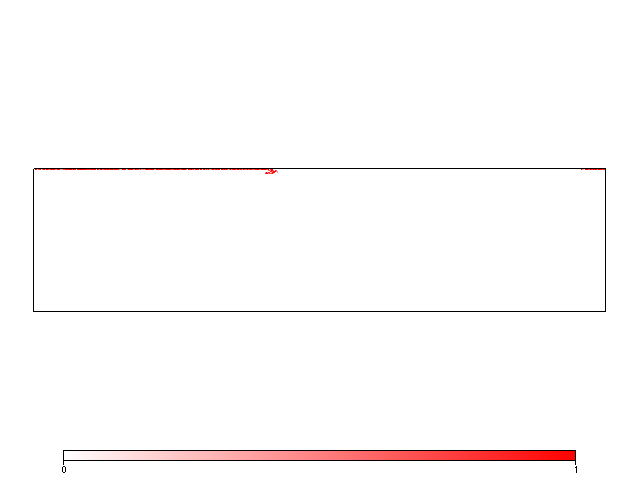

In [170]:
#Pack some stuff into a database as well
figYield = glucifer.Figure()
figYield.append( glucifer.objects.Points(gSwarm,yieldingCheck, colours='white red'))
#figYield.show()

In [111]:
#surfswarmVel.data[:,0] = velocityField.evaluate(surfswarm)[:,0] #update the swarm
#vel_surface = velocityField._evaluate_global(TWalls)
#if uw.rank() == 0:
#    fnametemp = "surfaceswarm" + "_" + str(ModIt) + "_" + str(step) + ".hdf5"
#    fullpath = os.path.join(outputPath + "files/" + fnametemp)
#    np.save(fullpath, vel_surface)
    


In [199]:
# surf_coords = [0.75, 0.5]
velocityField._evaluate_global(np.array(surf_coords))
#np.array(surf_coords).shape

array([[  -1.61262798,   -0.64733371],
       [  -4.83788393,   -0.7316643 ],
       [  -8.06313988,   -0.81599488],
       ..., 
       [-143.56987637,   14.26277418],
       [ -86.14192582,   15.42668816],
       [ -28.71397527,   16.59060214]])

In [150]:
surfswarmVel.data.shape

(3000, 1)

In [130]:
temperatureField._evaluate_global.im_class

underworld.mesh._meshvariable.MeshVariable

In [151]:
np.array(surf_coords).shape

(1000, 2)

In [1]:
#figDb.show()